# Explore differences in aromatic amino acid genes

This notebook compares the expression activity of genes related to the aromatic amino acid pathway between PAO1 and PA14 strains using both RNA-seq and array compendia. The goal is to determine if the differences in expression activity between PAO1 vs PA14 are consistent using both RNA-seq and array compendia.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from scripts import paths

## Load expression compendia

In [2]:
# RNA-seq compendia files
rnaseq_pao1_compendium_filename = paths.PAO1_COMPENDIUM
rnaseq_pa14_compendium_filename = paths.PA14_COMPENDIUM

# Array compendia files
array_pao1_compendium_filename = paths.PAO1_COMPENDIUM_ARRAY
array_pa14_compendium_filename = paths.PA14_COMPENDIUM_ARRAY

In [3]:
# Load expression data
rnaseq_pao1_compendium = pd.read_csv(
    rnaseq_pao1_compendium_filename, sep="\t", index_col=0, header=0
)
rnaseq_pa14_compendium = pd.read_csv(
    rnaseq_pa14_compendium_filename, sep="\t", index_col=0, header=0
)

array_pao1_compendium = pd.read_csv(
    array_pao1_compendium_filename, sep="\t", index_col=0, header=0
)
array_pa14_compendium = pd.read_csv(
    array_pa14_compendium_filename, sep="\t", index_col=0, header=0
)

## Load KEGG pathways

In [4]:
# Load KEGG pathway data
pao1_pathway_filename = "../3_core_core_analysis/pao1_kegg_annot.tsv"
pa14_pathway_filename = "../3_core_core_analysis/pa14_kegg_annot.tsv"

In [5]:
pao1_pathways = pd.read_csv(pao1_pathway_filename, sep="\t", header=0, index_col=0)
pa14_pathways = pd.read_csv(pa14_pathway_filename, sep="\t", header=0, index_col=0)

In [6]:
print(pao1_pathways.shape)
pao1_pathways.head()

(123, 3)


,pathway_name,num_genes,gene_ids
pathway_id_name,,,
path:pae00010 : Glycolysis / Gluconeogenesis,Glycolysis / Gluconeogenesis,37,"['PA3193', 'PA4732', 'PA5110', 'PA0555', 'PA47..."
path:pae00020 : Citrate cycle (TCA cycle),Citrate cycle (TCA cycle),28,"['PA1580', 'PA1562', 'PA1787', 'PA2623', 'PA26..."
path:pae00030 : Pentose phosphate pathway,Pentose phosphate pathway,28,"['PA4732', 'PA5439', 'PA3183', 'PA3182', 'PA42..."
path:pae00040 : Pentose and glucuronate interconversions,Pentose and glucuronate interconversions,8,"['PA2022', 'PA3559', 'PA2023', 'PA0607', 'PA23..."
path:pae00051 : Fructose and mannose metabolism,Fructose and mannose metabolism,19,"['PA2344', 'PA3551', 'PA2232', 'PA5452', 'PA53..."


In [7]:
print(pa14_pathways.shape)
pa14_pathways.head()

(123, 3)


,pathway_name,num_genes,gene_ids
pathway_id_name,,,
path:pau00010 : Glycolysis / Gluconeogenesis,Glycolysis / Gluconeogenesis,37,"['PA14_22930', 'PA14_62620', 'PA14_67490', 'PA..."
path:pau00020 : Citrate cycle (TCA cycle),Citrate cycle (TCA cycle),28,"['PA14_44070', 'PA14_44290', 'PA14_41470', 'PA..."
path:pau00030 : Pentose phosphate pathway,Pentose phosphate pathway,28,"['PA14_62620', 'PA14_71800', 'PA14_23070', 'PA..."
path:pau00040 : Pentose and glucuronate interconversions,Pentose and glucuronate interconversions,8,"['PA14_38360', 'PA14_18300', 'PA14_38350', 'PA..."
path:pau00051 : Fructose and mannose metabolism,Fructose and mannose metabolism,18,"['PA14_34340', 'PA14_18380', 'PA14_71970', 'PA..."


## Get aromatic amino acid genes

In [8]:
# Aromatic amino acid pathways
# Are there others to include?
# https://docs.google.com/spreadsheets/d/1pDehBGTyCN0hTrlvbBNymeI640Sl68XlUBwBU8aPZTA/edit#gid=2100140648
pao1_aa_pathways = [
    "path:pae00362 : Benzoate degradation",
    "path:pae00350 : Tyrosine metabolism",
    "path:pae00620 : Pyruvate metabolism",
    "path:pae01220 : Degradation of aromatic compounds",
]

pa14_aa_pathways = [
    "path:pau00362 : Benzoate degradation",
    "path:pau00350 : Tyrosine metabolism",
    "path:pau00620 : Pyruvate metabolism",
    "path:pau01220 : Degradation of aromatic compounds",
]

In [9]:
# Select associated gene sets
def get_associated_genes(pathway_db, selected_pathways):
    aa_genes = set()
    for gene_set in pathway_db.loc[selected_pathways, "gene_ids"]:
        gene_set_processed = set(json.loads(gene_set.replace("'", '"')))
        aa_genes = aa_genes.union(gene_set_processed)

    return list(aa_genes)

In [10]:
pao1_aa_genes = get_associated_genes(pao1_pathways, pao1_aa_pathways)
print(pao1_aa_genes, len(pao1_aa_genes))

['PA0447', 'PA3452', 'PA2531', 'PA4847', 'PA1587', 'PA3896', 'PA4329', 'PA4470', 'PA4848', 'PA5436', 'PA5192', 'PA2007', 'PA4123', 'PA0480', 'PA0232', 'PA1821', 'PA3524', 'PA0954', 'PA2382', 'PA0927', 'PA4127', 'PA0247', 'PA4829', 'PA4733', 'PA4771', 'PA0482', 'PA0230', 'PA1748', 'PA3687', 'PA2553', 'PA2266', 'PA1628', 'PA4092', 'PA4486', 'PA2940', 'PA3589', 'PA1017', 'PA2470', 'PA1736', 'PA0231', 'PA4152', 'PA0836', 'PA1966', 'PA0494', 'PA3165', 'PA1498', 'PA2001', 'PA1629', 'PA2108', 'PA3139', 'PA4640', 'PA1982', 'PA4772', 'PA1217', 'PA4122', 'PA1737', 'PA0265', 'PA3629', 'PA3454', 'PA0153', 'PA0870', 'PA4022', 'PA2517', 'PA4128', 'PA5435', 'PA5016', 'PA0832', 'PA4333', 'PA0421', 'PA4872', 'PA1813', 'PA2009', 'PA4124', 'PA3426', 'PA1027', 'PA3792', 'PA3013', 'PA2508', 'PA1770', 'PA2555', 'PA5046', 'PA0854', 'PA4899', 'PA2473', 'PA0710', 'PA2507', 'PA4447', 'PA0493', 'PA1984', 'PA1135', 'PA4785', 'PA5427', 'PA0865', 'PA2509', 'PA5015', 'PA3925', 'PA3112', 'PA0228', 'PA4091', 'PA0242',

In [11]:
pa14_aa_genes = get_associated_genes(pa14_pathways, pa14_aa_pathways)
print(pa14_aa_genes, len(pa14_aa_genes))

['PA14_32690', 'PA14_19470', 'PA14_53510', 'PA14_63250', 'PA14_56300', 'PA14_11190', 'PA14_62630', 'PA14_02790', 'PA14_38530', 'PA14_31820', 'PA14_53470', 'PA14_38630', 'PA14_58220', 'PA14_64740', 'PA14_41080', 'PA14_35150', 'PA14_17400', 'PA14_02840', 'PA14_37340', 'PA14_66680', 'PA14_55130', 'PA14_32100', 'PA14_15030', 'PA14_63850', 'PA14_38860', 'PA14_57770', 'PA14_05480', 'PA14_32230', 'PA14_45050', 'PA14_10620', 'PA14_31530', 'PA14_06450', 'PA14_11000', 'PA14_61400', 'PA14_05840', 'PA14_25080', 'PA14_03050', 'PA14_63090', 'PA14_51170', 'PA14_71740', 'PA14_13090', 'PA14_64110', 'PA14_10640', 'PA14_01910', 'PA14_69925', 'PA14_26010', 'PA14_52800', 'PA14_02850', 'PA14_53220', 'PA14_32240', 'PA14_43460', 'PA14_10630', 'PA14_32110', 'PA14_17860', 'PA14_41950', 'PA14_10570', 'PA14_41670', 'PA14_10650', 'PA14_19430', 'PA14_53070', 'PA14_10240', 'PA14_66290', 'PA14_40980', 'PA14_58030', 'PA14_71720', 'PA14_19190', 'PA14_17270', 'PA14_32670', 'PA14_66310', 'PA14_25090', 'PA14_10590', 'PA14

## Get expression activity of aromatic amino acid genes

In [12]:
# Select rna-seq genes that are related to AA pathways
rnaseq_pao1_aa_expression = rnaseq_pao1_compendium[pao1_aa_genes]
rnaseq_pa14_aa_expression = rnaseq_pa14_compendium[pa14_aa_genes]

rnaseq_pao1_aa_expression.head()

,PA0447,PA3452,PA2531,PA4847,PA1587,PA3896,PA4329,PA4470,PA4848,PA5436,...,PA0154,PA0968,PA2516,PA4121,PA0835,PA0887,PA2275,PA2008,PA3639,PA5297
ERX541571,400.965702,5465.663720,110.265568,508.725234,4380.550290,100.241425,182.940601,80.193140,7290.057662,132.819889,...,32.578463,1170.318642,15.036214,35.084499,631.520980,1566.272272,40.096570,75.181069,1445.982561,275.663920
ERX541572,283.378761,4613.347501,127.740685,462.509377,4299.134781,152.701509,189.408602,64.604484,7266.536213,124.804118,...,24.960824,1723.765107,22.024256,4.404851,569.694090,2447.628989,38.175377,88.097024,1741.384512,161.511211
ERX541573,116.985057,765.003403,139.330517,804.436569,2571.042366,136.701639,202.423581,115.670618,6787.762157,260.258890,...,42.062043,1892.791926,10.515511,6.572194,640.131714,7180.779370,32.860971,223.454602,1422.222822,165.619294
ERX541574,123.771727,621.238862,164.235561,664.082921,2784.863863,149.954208,245.163229,83.307893,8073.724976,266.585259,...,52.364962,1930.362900,4.760451,7.140677,428.440594,4039.242714,28.562706,233.262101,963.991337,164.235561
ERX541575,94.852347,1017.686640,124.493705,853.671123,2414.782668,154.135064,231.202596,94.852347,5102.265833,306.294037,...,49.402264,2406.878306,23.713087,1.976091,353.720211,4637.884551,19.760906,124.493705,1505.781009,169.943788


In [13]:
# Select array genes that are related to AA pathways
shared_pao1_aa_genes = set(pao1_aa_genes).intersection(array_pao1_compendium.columns)
array_pao1_aa_expression = array_pao1_compendium[shared_pao1_aa_genes]
array_pa14_aa_expression = array_pa14_compendium[shared_pao1_aa_genes]

array_pao1_aa_expression.head()

,PA3452,PA2531,PA1587,PA4329,PA4470,PA4848,PA3524,PA0954,PA0927,PA0247,...,PA3590,PA3226,PA0154,PA0968,PA4121,PA2516,PA0835,PA3639,PA0887,PA2509
GSM92174.CEL,6.702584,6.619592,10.139970,10.071413,9.641198,9.251546,8.247743,6.683608,7.686544,6.042704,...,6.508075,7.435273,9.888153,8.354572,5.868986,5.798473,8.876875,7.746923,12.712979,5.702281
GSM629178.CEL,9.563090,6.384079,10.878184,10.321643,6.250481,10.536418,9.936431,6.214632,7.161619,5.793044,...,6.174423,6.951654,7.250878,9.553712,6.187437,5.911328,8.883359,9.028361,11.173653,5.488186
MBU_JGOLD_pakA1.CEL,7.242215,6.898976,9.470220,8.820462,10.433906,8.144151,8.620363,6.510976,6.736870,5.860376,...,6.501579,8.641465,7.725667,8.596650,5.813497,6.386882,7.683518,7.686158,11.355140,5.876882
GSM838206_OXYR-LB-1_Pae_G1a.CEL,6.161731,6.401400,9.815225,9.611355,6.349506,8.868361,9.210089,7.880940,7.203974,6.139236,...,6.347774,6.875030,8.021694,8.053113,5.979658,5.829577,8.676601,8.647822,12.609323,6.881116
GSM267248.CEL,7.632249,7.075901,9.887665,10.029942,6.070739,9.938050,9.473968,5.738971,6.968943,6.123059,...,6.778437,6.672580,7.775345,8.937982,6.445793,5.679869,9.091717,8.322194,7.252386,6.615613


In [14]:
# Calculate median across samples
rnaseq_pao1_aa_expression_median = rnaseq_pao1_aa_expression.median()
rnaseq_pa14_aa_expression_median = rnaseq_pa14_aa_expression.median()

array_pao1_aa_expression_median = array_pao1_aa_expression.median()
array_pa14_aa_expression_median = array_pa14_aa_expression.median()

In [15]:
# Calculate difference in median of medians
diff_rnaseq = abs(
    rnaseq_pao1_aa_expression_median.median()
    - rnaseq_pa14_aa_expression_median.median()
)
diff_rnaseq

38.512788560844484

In [16]:
diff_array = abs(
    array_pao1_aa_expression_median.median() - array_pa14_aa_expression_median.median()
)
diff_array

0.037075178674999876

## Plot

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


Text(0.5, 0, 'Median expression')

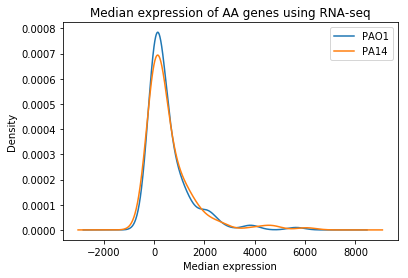

In [17]:
# Plot box plot of rna-seq and array
rnaseq_pao1_aa_expression_median.plot(kind="density", label="PAO1", legend=True)
rnaseq_pa14_aa_expression_median.plot(kind="density", label="PA14", legend=True)
plt.title("Median expression of AA genes using RNA-seq")
plt.xlabel("Median expression")

Text(0.5, 0, 'Median expression')

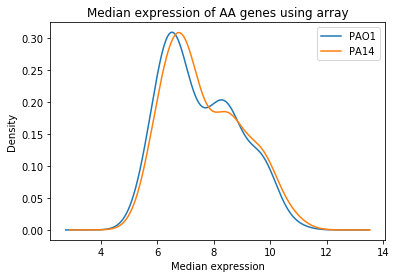

In [18]:
array_pao1_aa_expression_median.plot(kind="density", label="PAO1", legend=True)
array_pa14_aa_expression_median.plot(kind="density", label="PA14", legend=True)
plt.title("Median expression of AA genes using array")
plt.xlabel("Median expression")